<a href="https://colab.research.google.com/github/BawBaw31/python-data/blob/master/pumpkins-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cours 2 - Construisons un modèle de régression !
Duquesne - 2022

Le materiel de cours à été adapté à partir de [ce site](https://github.com/microsoft/ML-For-Beginners)

La libraire de Machine Learning que nous allons utiliser aujourd'hui s'appelle scikit-learn: https://scikit-learn.org/stable/index.html

In [244]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

Aujourd'hui, nous allons explorer notre pipeline de Machine Learning (ML) avec un ensemble de données sur les citrouilles. Le modèle de ML que nous allons découvrir est la régression linéaire (et la régression polynomiale).

## Avec quel type de données est-ce que je travaille ?

Le jeu de données sur les citrouilles est proposé par [ce projet](https://www.kaggle.com/datasets/usda/a-year-of-pumpkin-prices) sur Kaggle et ses données proviennent des "Specialty Crops Terminal Markets Standard Reports" distribués par le ministère de l'Agriculture des États-Unis. Certains points autour de la couleur basée sur la variété ont été ajoutés pour normaliser la distribution. Ces données sont dans le domaine public.

Chargez les données dans le notebook en exécutant la cellule suivante. Notre but est de comprendre avec quel type de données nous travaillons.
* Quelles sont mes données ? Que représentent-elles ? 
* Quels sont les types de données pour chacune de mes colonnes ?
* Ai-je des données manquantes ? Si oui, combien et pour quelles colonnes? 

In [245]:
import pandas as pd

pumpkins = pd.read_csv('US-pumpkins.csv', parse_dates=['Date'])

# remove row if Date is below 2016
pumpkins = pumpkins[pumpkins['Date'] >= '2016-01-01']

pumpkins["Item Size"].groupby(pumpkins["Item Size"]).count().sort_values(ascending=False).head(10)


Item Size
sml        363
med        337
lge        294
xlge       205
med-lge    133
jbo        127
exjbo       17
Name: Item Size, dtype: int64

Après quelques explorations, nous constatons que les données sont un peu en vrac. En fait, il n'est pas très courant de recevoir un jeu de données entièrement prêt à être utilisé pour créer un modèle de ML.     

Aujourd'hui, vous allez apprendre à préparer un jeu de données brut pour entraîner un modèle de ML.

## Quelle est la question que nous nous posons ? 

Avant de commencer à préparer nos données, il est important de considérer la question posée. 

En général, la question à laquelle vous devez répondre déterminera le type d'algorithmes ML que vous utiliserez. Et la qualité de la réponse que vous obtiendrez dépendra fortement de la nature de vos données.

Puisque nous travaillons avec un modèle de régression, une question que nous pourrions formuler avec nos données pourrait être : **"Pouvons-nous prédire le prix d'une citrouille pour un jour donné ? "**.    

Maintenant, en regardant à nouveau les données, il y a quelques changements que nous devons faire pour préparer les données à un modèle de regression (et de ML plus généralement).

## Comment préparer mes données ?

#### Colonnes pertinentes

Comme nous voulons prédire le prix pour un jour spécifique, certaines colonnes ne contiennent peut-être pas de données pertinentes pour nous. 

Commençons par garder que les colonnes pertinentes pour notre question :

In [246]:
new_columns = ['Name of column to keep'] #put names of columns to keep here
# pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

#### Extraction des jours

Puisque nous travaillons avec des dates, nous devons également extraire le jour de l'année (sur 365 jours) dans une nouvelle colonne. Dans cet ensemble de données, nous avons des dates américaines, donc le format est MM/DD/YYYY).

In [247]:
dayOfYear = pumpkins["Date"].dt.strftime("%j").astype(int)
# create a column for day of year
pumpkins["DayOfYear"] = dayOfYear

#### Prix moyen

Maintenant, nous avons également besoin du prix moyen de nos citrouilles. Pour cela, nous devons prendre la moyenne des colonnes `Low Price` et `High Price` pour remplir une colonne `Average Price`.

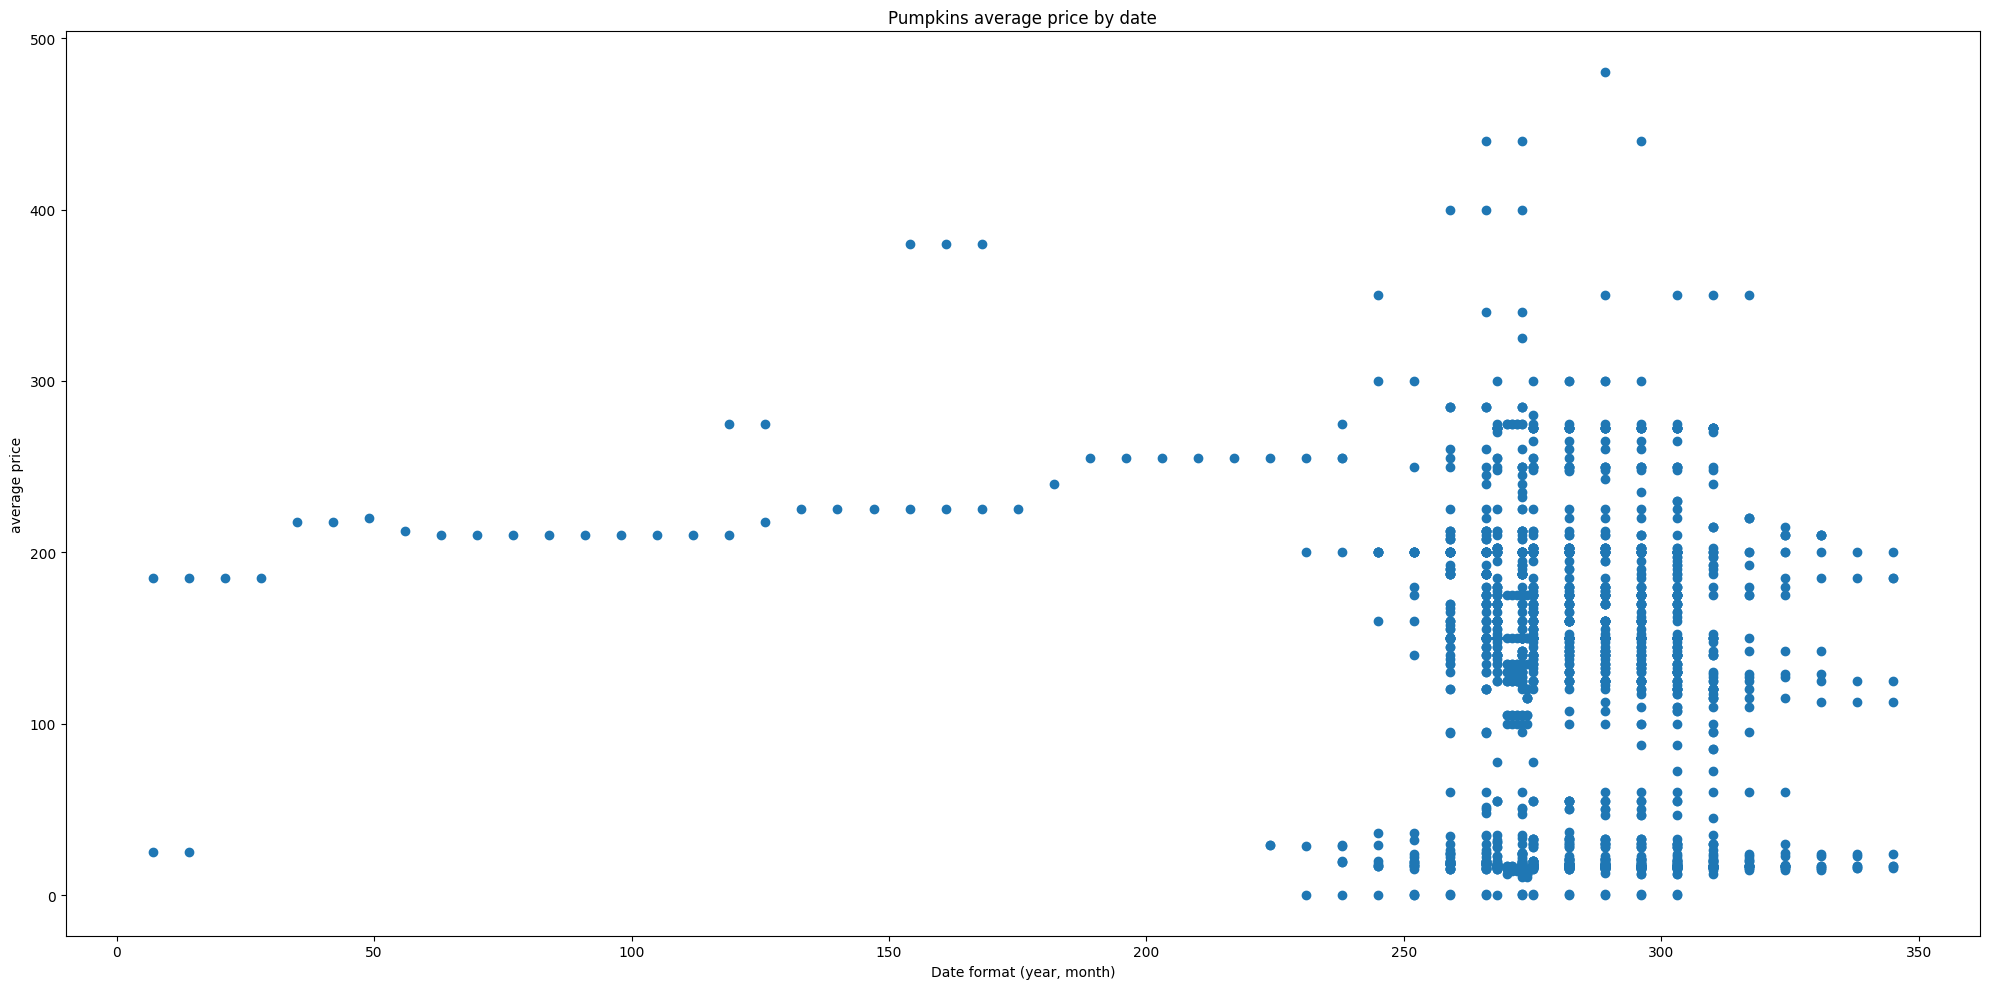

In [248]:
#Your code

y_prices = pumpkins.drop([c for c in pumpkins.columns if c not in ["High Price"] and c not in ["Low Price"]], axis=1).mean(axis=1)
pumpkins["Price"] = y_prices


# resize graph
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)
# plot
plt.scatter(dayOfYear, y_prices)
plt.title('Pumpkins average price by date')
plt.xlabel('Date format (year, month)')
plt.ylabel('average price')
plt.tight_layout()
plt.show()
f.savefig("img/pumpkins-2.png")

#### Données Manquantes

Avons-nous des valeurs manquantes dans notre ensemble de données ? Il semble que nous ayons de la chance ici, mais dans la plupart des cas, savoir comment traiter les données manquantes est une étape importante de la préparation des données. [Cet article](https://www.analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/) explique les possibilités qui s'offrent à nous lorsque nous sommes confrontés à des données manquantes.

In [249]:
# pumpkins.isnull().sum()

#### Mais attendez ! Il y a quelque chose de bizarre ici.

Si vous regardez la colonne `Package`, les citrouilles sont vendues dans de nombreuses configurations différentes. Certaines sont vendues dans des mesures de "1 1/9 bushel", d'autres dans des mesures de "1/2 bushel", certaines par citrouille, d'autres par pound (=livre), et d'autres encore dans de grandes boîtes de différentes largeurs.

In [250]:
# pumpkins['Unit of Sale'].unique()

In [251]:
# pumpkins['Package'].unique()

En creusant dans les données originales, il est intéressant de constater que tous les produits dont la `Unit of Sale` est égale à "EACH" ou "PER BIN" ont également le type de colis par inch, par bin ou "each". Les citrouilles semblent être très difficiles à peser de manière cohérente.

Pour pouvoir comparer les prix de nos citrouilles de manière cohérente, nous devons transformer nos données afin d'obtenir le même rapport prix/quantité dans chaque ligne de données. 

Pour y parvenir, nous pouvons filtrer nos données en sélectionnant uniquement les citrouilles dont la colonne `Package` contient des mesures par "bushel". Ou nous pourrions essayer de normaliser le prix pour 1 livre de citrouilles, ou bien pour 1 kg de citrouilles.

Toute cette étude sur les [boisseaux](https://fr.wikipedia.org/wiki/Boisseau) de citrouilles montre à quel point il est important de comprendre la nature de vos données !

Note : *Selon [The Spruce Eats](https://www.thespruceeats.com/how-much-is-a-bushel-1389308), le poids d'un boisseau dépend du type de produit, car il s'agit d'une mesure de volume. " Un boisseau de tomates, par exemple, est censé peser 56 livres... ". Les feuilles et les légumes verts occupent plus d'espace et pèsent moins. Ainsi, un boisseau d'épinards ne pèse que 10 livres "*.

Note : *Avez-vous remarqué que les citrouilles vendues au demi-boisseau sont très chères ? Pouvez-vous comprendre pourquoi ? Indice : les petites citrouilles sont beaucoup plus chères que les grosses, probablement parce qu'il y en a beaucoup plus par boisseau, étant donné l'espace utilisé par une grosse citrouille.

In [252]:
# Your code

#### Visualisation de nos données

La représentation visuelle de vos données peut vous permettre de découvrir des relations cachées dont vous pouvez tirer parti. Vos visualisations peuvent également vous aider à découvrir des biais ou des données déséquilibrées.

Pour avoir une première intuition sur nos données :
* Tracez un diagramme à barres du prix moyen des citrouilles par mois.
* Tracez un nuage de points des prix des citrouilles par mois.

Que remarquons-nous sur nos graphiques ? Avons-nous des valeurs aberrantes ? 
Si vous voulez vous rappeler ce qu'est une valeur aberrante et comment les traiter, je vous suggère [l'article suivant](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/).

In [253]:
#Your code

Vous êtes maintenant prêt à plonger plus profondément dans la régression. Alors que la visualisation vous permet de donner un sens aux données, le véritable pouvoir de l'apprentissage automatique provient de la création de modèles. Les modèles sont formés sur des données antérieures pour capturer automatiquement les liens entre les données, et ils vous permettent de prédire les résultats pour les nouvelles données.

## Diviser nos données

Avant de former notre modèle, nous devons diviser votre ensemble de données en deux ou plusieurs parties de taille inégale qui représentent toujours bien nos données.

* Données d'entraînement (Training data). Cette partie de l'ensemble de données est destinée à l'entraînement de votre modèle. Cet ensemble constitue la majorité de l'ensemble de données original.
* Test (Testing data). C'est cette partie de l'ensemble de données, qui constitue la minorité de votre ensemble de données, que vous utilisez pour evaluer la performance du modèle construit.
* Validation. Un ensemble de validation est un groupe indépendant d'exemples que vous utilisez pour ajuster les hyperparamètres du modèle, ou son architecture, afin de l'améliorer. Selon la taille de vos données et la question que vous posez, vous n'aurez peut-être pas besoin de construire ce troisième ensemble. 

Nous n'utiliserons pas de données de validation aujourd'hui.

Nous commençons donc par séparer les valeurs d'entrée ( features ) et la sortie attendue ( label ) dans des tableaux séparés :

In [254]:
# X = new_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
# y = new_pumpkins['Price']
X_dates = dayOfYear.to_numpy().reshape(-1,1)
y_prices = y_prices.to_numpy().reshape(-1,1)

*Notez que nous avons dû effectuer un remodelage des données d'entrée. La fonction de régression linéaire attend un tableau 2D, où chaque ligne du tableau correspond à un vecteur de caractéristiques d'entrée. Dans notre cas, puisque nous n'avons qu'une seule entrée, nous avons besoin d'un tableau de forme N×1, où N est la taille de l'ensemble de données.*

Ensuite, nous devons diviser les données en ensembles de données de training et de test, afin de pouvoir valider notre modèle par la suite:

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X_dates, y_prices, test_size=0.3)


In [256]:
type(X_dates), type(y_prices)

(numpy.ndarray, numpy.ndarray)

## Entraînement de notre modèle

En utilisant vos données d'entraînement, votre objectif est de construire un modèle, ou une représentation statistique de vos données, en utilisant divers algorithmes pour l'entraîner, ici un modèle de régression. L'entraînement d'un modèle l'expose aux données et lui permet de faire des suppositions sur les patterns perçus qu'il découvre.

Pour un bref rappel, le but d'une régression linéaire est de pouvoir tracer une ligne pour :

* Montrer la relation entre les variables, entre une variable dépendante et une variable indépendante.
* Faire des prédictions précises sur l'emplacement d'un nouveau point de données par rapport à cette ligne.

Pour cela le modèle calcule la distance entre tous les points de données autour de la ligne de régression. Idéalement, cette distance est la plus petite possible.

Si vous souhaitez en savoir plus sur la régression linéaire et la régression polynomiale, voici un [bon article](https://haltode.fr/algo/ia/apprentissage_artificiel/regression_lin_poly.html) qui récapitule les concepts clés. 

La création du modèle de régression linéaire proprement dit ne nécessite qu'une ligne de code. Nous définissons l'objet LinearRegression et l'adaptons à nos données à l'aide de la méthode fit :

In [257]:
lin_reg = LinearRegression().fit(X_train,y_train)

L'objet `LinearRegression` après entrainement contient tous les coefficients de la régression, qui peuvent être accédés en utilisant la propriété `.coef_`. Dans notre cas, il n'y a qu'un seul coefficient. Nous pouvons également accéder au point d'intersection de la régression avec l'axe des Y en utilisant la propriété `lin_reg.intercept_`. 

## Évaluation de notre modèle

Pour voir à quel point notre modèle est précis, nous pouvons prédire les prix sur un ensemble de données de test, puis mesurer la perte de nos prédictions par rapport aux valeurs attendues. Pour ce faire, on utilise la mesure de l'erreur quadratique moyenne ( root mean square error = RMSE), qui est la racine carrée de la moyenne de toutes les différences au carré entre la valeur attendue et la valeur prédite. (Pour plus d'explications : https://www.youtube.com/watch?v=N6y5wqdIBas) 

In [258]:
pred = lin_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test,pred))
# mse = mean_squared_error(y_test,pred)
print(f'Mean error: {rmse:3.3} ({rmse/np.mean(pred)*100:3.3}%)')

Mean error: 86.0 (66.9%)


Un autre indicateur de la qualité du modèle est le coefficient de détermination, qui peut être obtenu comme suit :

In [259]:
score = lin_reg.score(X_train,y_train)
print('Model determination: ', score)

Model determination:  0.02177197758164784


Si la valeur est 0, cela signifie que le modèle ne prend pas en compte les données d'entrée, et agit comme le pire prédicteur linéaire, qui est simplement une valeur moyenne du résultat. La valeur de 1 signifie que nous pouvons parfaitement prédire toutes les sorties attendues. (Pour plus d'explications : https://www.youtube.com/watch?v=6LBTmVv3K_Q)

**A quel point votre modèle arrive à prédire correctement des données?**

Nous pouvons également tracer les données de test avec la ligne de régression pour mieux voir comment la régression fonctionne dans notre cas :

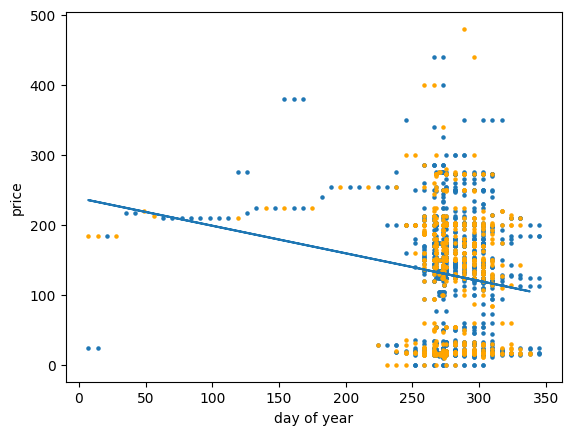

In [260]:
plt.scatter(X_train,y_train, s = 5) #Training data
plt.scatter(X_test,y_test, color = "orange", s = 5) #Test data
plt.plot(X_test, pred) #Regression line
plt.xlabel("day of year")
plt.ylabel("price")
plt.show()

**Quel prix de la citrouille notre modèle prévoit-il pour le 10 octobre ?**

## Iteration

Maintenant que nous savons comment créer notre modèle, notre objectif est de l'améliorer encore. Pour y parvenir, nous avons principalement trois options :
* Peut-être que dans notre cas, le prix dépend de la variété des citrouilles ? Essayons de ré-entraîner un modèle avec le prix, la variété et les jours de l'année.
* Peut-être que nos données ne suivent pas une relation linéaire ? Essayez de ré-entraîner un modèle en utilisant la régression polynomiale au lieu de la régression linéaire.
* Réévaluer notre question. Notre question est-elle suffisamment précise ? Nos données nous permettent-elles de former un modèle qui puisse répondre à notre question ? 

#### Ajout des variétés de citrouille comme données d'entrée pour notre modèle 

Dans un monde idéal, nous voulons être en mesure de prédire les prix de différentes variétés de citrouilles en utilisant le même modèle. Cependant, la colonne `Variety` est quelque peu différente des colonnes comme `Average Price`, car elle contient des valeurs non numériques. Ces colonnes sont dites catégoriques.

Tracez un scatterplot du prix en fonction du jour de l'année avec des couleurs pour chaque variété de nos citrouilles. 
* Qu'observez-vous ? 
* Combien de citrouilles avons-nous dans chaque variété ? 
* La même variété de citrouilles est-elle vendue toute l'année ?

In [261]:
#Your code

Pour prendre en compte la variété, nous devons d'abord la convertir sous forme numérique, ou la coder. Il y a plusieurs façons de le faire :

* Le codage numérique simple va construire une table des différentes variétés, puis remplacer le nom de la variété par un index dans cette table. Ce n'est pas la meilleure idée pour la régression linéaire, parce que la régression linéaire prend la valeur numérique réelle de l'indice, et l'ajoute au résultat, en le multipliant par un certain coefficient. Dans notre cas, la relation entre le numéro de l'indice et le prix est clairement non linéaire, même si nous nous assurons que les indices sont ordonnés d'une manière spécifique.
* One hot encoding remplacera la colonne Variété par des colonnes différentes, une pour chaque variété. Chaque colonne contiendra 1 si la ligne correspondante est d'une variété donnée, et 0 sinon. Cela signifie qu'il y aura quatre coefficients dans la régression linéaire, un pour chaque variété de citrouille, responsable du "prix de départ" (ou plutôt du "prix supplémentaire") pour cette variété particulière.


Le code ci-dessous montre comment nous pouvons coder un one hot encoding:

In [262]:
pd.get_dummies(pumpkins['Variety'])
pd.get_dummies(pumpkins['Item Size'])

,exjbo,jbo,lge,med,med-lge,sml,xlge
0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
1752,0,0,0,0,0,0,0
1753,0,0,0,0,0,1,0
1754,0,0,0,0,0,1,0
1755,0,0,0,0,0,1,0


Maintenant, ajoutons toutes nos étapes ensemble :

In [263]:
#Seperating input and output
X = pd.get_dummies(pumpkins['Item Size']).join(pd.get_dummies(pumpkins['Variety']).join(pumpkins["DayOfYear"]))
y = y_prices

# make train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train model
pipeline = LinearRegression().fit(X_train,y_train)

# predict results for test data
pred = pipeline.predict(X_test)

# calculate MSE and determination
rmse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {rmse:3.3} ({rmse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 64.9 (49.8%)
Model determination:  0.4030840478835951


**A quel point votre modèle arrive à prédire correctement des données maintenant ?**

#### Regression Polynomiale

Un autre type de régression est la régression polynomiale. Bien qu'il existe parfois une relation linéaire entre les variables (plus le volume est important, plus le prix est élevé), il arrive que ces relations ne puissent pas être représentées par un plan ou une ligne droite.

Regardez à nouveau la relation entre la date et le prix. Ce nuage de points vous semble-t-il devoir être nécessairement analysé par une ligne droite ? Les prix ne peuvent-ils pas fluctuer ? Dans ce cas, vous pouvez essayer la régression polynomiale.

La régression polynomiale crée une ligne courbe pour mieux s'adapter aux données non linéaires. Dans notre cas, si nous incluons une variable `DayOfYear` au carré dans les données d'entrée, nous devrions pouvoir ajuster nos données avec une courbe parabolique, qui aura un minimum à un certain point de l'année.

Scikit-learn comprend une API de pipeline utile pour combiner différentes étapes du traitement des données. Un pipeline est une chaîne d'estimateurs. Dans notre cas, nous allons créer un pipeline qui ajoute d'abord des caractéristiques polynomiales à notre modèle, puis entraîne la régression :

In [264]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

Maintenant, si on met toutes nos étapes ensemble, on obtient :

Mean error: 84.8 (65.0%)
Model determination:  0.02819850370359045


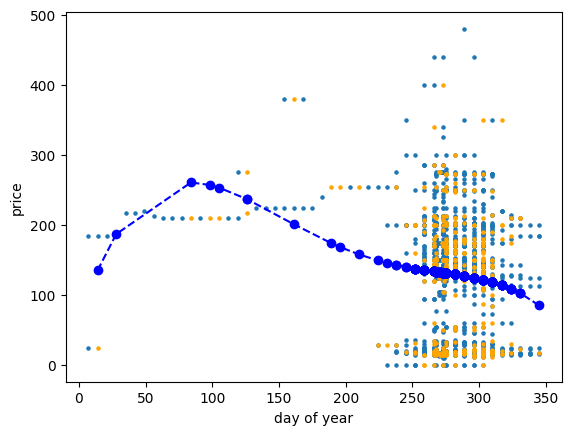

In [265]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#Seperating input and output
X = pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pumpkins['Price']

# make train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train model
pipeline = make_pipeline(PolynomialFeatures(4), LinearRegression())
pipeline.fit(X_train,y_train)

# predict results for test data
pred = pipeline.predict(X_test)

# calculate MSE and determination
mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_train,y_train, s = 5) #Training data
plt.scatter(X_test,y_test, color = "orange", s = 5) #Test data
reg_x, reg_y = zip(*sorted(zip(X_test[:,0], pred))) #Sorting data to get a nice plot
plt.plot(reg_x, reg_y, '--bo') #Regression line
plt.xlabel("day of year")
plt.ylabel("price")
plt.show()




**A quel point votre modèle arrive à prédire correctement des données maintenant ?**

## A vous de jouer ! 

Maintenant que nous avons vu les étapes clés dans la création d'un modèle de regression, à vous de creer vos itérations pour créer le meilleur modèle possible ! 
Vous serez évalués sous la forme d'un rapport. Le template du rapport est disponible dans le [drive](https://docs.google.com/document/d/16arpyMok-Z4hC0_GJ_7URn6oxHMfvdunM0Tdk5oxbgs/edit#).
Pensez à bien visualiser vos données pour bien les comprendre et soyez créatifs :)